#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  """
    Параметры
    X : np.ndarray (n_objects, n_features)
        Каждая строка — это объект, каждый столбец — это признак
    y : np.ndarray формы (n_objects,)
        Вектор правильных ответов (классов), где обычно y ∈ {-1, +1}
    w : np.ndarray (n_features,)
        Вектор весов (коэффициентов модели)
    w0 : float
        Смещение (intercept, свободный член)
    gamma : float
        Коэффициент для L1-регуляризации (регуляризация по норме L1, "Lasso")
        Контролирует степень разреженности весов
    beta : float
        Коэффициент для L2-регуляризации (регуляризация по норме L2, "Ridge")
        Контролирует силу штрафа за большие веса
    Возвращает
    total_loss : float
        Полное значение функции потерь (логистическая + регуляризации)
  """
  n_objects = X.shape[0]
  z = y * (X @ w + w0)
  logistic_loss = np.mean(np.log(1 + np.exp(-z))) # Логистическая функция потерь
  l1_reg = gamma * np.sum(np.abs(w))
  l2_reg = beta * np.sum(w**2)
  total_loss = logistic_loss + l1_reg + l2_reg # Полная функция потерь - сумма логистической потери и регуляризаторов

  return total_loss

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: np.ndarray, w0: float, gamma=1., beta=1.) -> Tuple[np.ndarray, float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    n_objects = X.shape[0]
    z = y * (X @ w + w0)
    sigmoid = 1 / (1 + np.exp(-z))
    grad_w = -np.mean(X * (y * (1 - sigmoid))[:, np.newaxis], axis=0) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = -np.mean(y * (1 - sigmoid))
    return grad_w, grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        beta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: насколько маленьким должно стать изменение весов, чтобы остановиться
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None # веса модели - вектор коэфф-тов
        self.w0 = None # свободный член
        self.loss_history = [] # история изменения функции потерь по итерациям

    # обучение модели при помощи градиентного спуска
    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_objects, n_features = X.shape

        # инициализируем веса случайными числами
        self.w = np.random.normal(size=n_features)
        self.w0 = np.random.normal()

        # преобразуем метки классов 0 в -1 для удобства формулы потерь
        y_modified = np.copy(y)
        y_modified[y_modified == 0] = -1

        for i in range(self.max_iter):
            # вычисляем градиенты
            grad_w, grad_w0 = get_grad(X, y_modified, self.w, self.w0, self.gamma, self.beta)

            # обновление весов с помощью стохастического градиентного спуска
            new_w = self.w - self.lr * grad_w
            new_w0 = self.w0 - self.lr * grad_w0

            # вычисляем значение ф-ии потерь и сохр в историю
            current_loss = loss(X, y_modified, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

            # проверка условия сходимости: если изменения весов стали меньше tolerance, то обучение завершается
            if np.linalg.norm(new_w - self.w) < self.tolerance and abs(new_w0 - self.w0) < self.tolerance:
                break

            self.w = new_w
            self.w0 = new_w0


    def predict(self, X):
        '''
        Функция предсказывает метки классов (0 или 1) и возвращает предсказанные классы для каждого объекта
        '''
        if self.w is None or self.w0 is None:
            raise RuntimeError("Модель еще не обучена.")

        # Линейная комбинация признаков
        linear_output = X @ self.w + self.w0

        # Если результат больше 0, то относим к классу 1, иначе - к 0
        return (linear_output > 0).astype(int)


    def predict_proba(self, X):
        '''
        Вычисляет и возвращает вероятности принадлежности объектов к классам 0 и 1
        '''
        if self.w is None or self.w0 is None:
            raise RuntimeError("Model has not been fitted yet.")

        # Линейная комбинация признаков
        linear_output = X @ self.w + self.w0

        # Применяем сигмоиду по формуле
        # Вероятность класса 1 это 1 / (1 + exp(-linear_output))
        # Вероятность класса 0 это (1 - вероят класса 1)
        proba_class_1 = 1 / (1 + np.exp(-linear_output))
        proba_class_0 = 1 - proba_class_1

        return np.vstack((proba_class_0, proba_class_1)).T

In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

Функция рисует точки из датасета и показывает, как логистическая регрессия
разделяет классы (границу между ними)

1. Рисуем точки X (по двум признакам) и окрашиваем их по меткам y.
2. Создание сетки координат, чтобы посчитать предсказания модели в каждой точке.
3. С помощью model.predict вычисляем, какой класс модель отнесёт к каждой точке сетки.
4. Закрашивание области разными цветами, показывая, где модель предсказывает 0 или 1.
5. Добавляем подписи осей и заголовок, вывод итогового график.

In [8]:
def plot_decision_boundary(model, X, y):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', edgecolors='k', s=50)

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                         np.linspace(ylim[0], ylim[1], 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Граница решений логистической регрессии")
    plt.show()

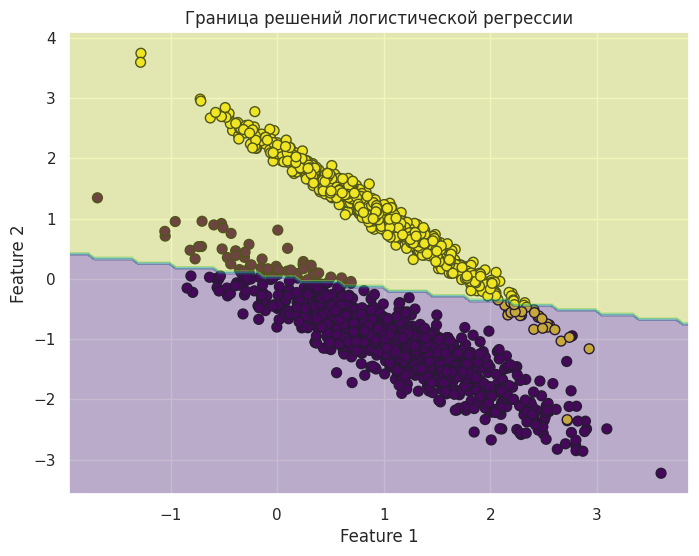

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [10]:
def plot_loss_history(model):
    plt.figure(figsize=(8, 6))
    plt.plot(model.loss_history)
    plt.xlabel("Итерация")
    plt.ylabel("Значение функции потерь")
    plt.title("Изменение функции потерь во время обучения")
    plt.grid(True)
    plt.show()

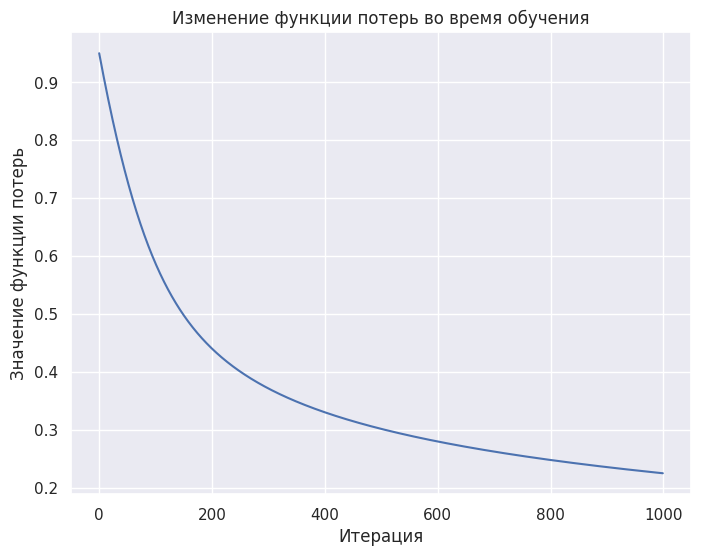

In [11]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

## Используем SVC из sklearn и сравним результаты с логистической регрессией

SVC — это классификатор, похожий на логистическую регрессию,
   но он ищет оптимальную разделяющую границу с максимально возможным зазором между классами

- Перед обучением заменяем метки -1 обратно на 0, потому что SVC ожидает классы {0, 1}, а не {-1, 1}.

- После этого вызываем fit(X, y), чтобы обучить модель на данных

In [17]:
# Создаем и обучем модель SVC
svc_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
# kernel: задаёт тип ядра (например, 'linear', 'poly', 'rbf'),
# который определяет форму границы решений
# C: регулирует силу штрафа за ошибки (меньше C — граница более "мягкая",
# больше C — модель старается точнее разделить все точки)
# probability=True — надо чтобы вычислять вероятности классов

# Обучаем модель
y_modified = np.copy(y)
y_modified[y_modified == -1] = 0 # Преобразуем -1 обратно в 0 для SVC
svc_model.fit(X, y_modified)

SVC(kernel='linear', probability=True, random_state=42)

In [18]:
y_pred = svc_model.predict(X)

## Считаем основные метрики качества модели

1. Accuracy — доля правильных предсказаний среди всех
2. Precision — насколько часто модель права, когда предсказывает класс 1
3. Recall — насколько хорошо модель находит все объекты класса 1
4. F1-Score — среднее между Precision и Recall
5. AUC-ROC — показывает, насколько хорошо модель различает классы по вероятностям

Они помогают понять, насколько хорошо обучилась модель и
не делает ли она слишком много ошибок при классификации

В данном случае по результатам метрик видно, что модель работает очень точно и почти не ошибается


In [19]:

accuracy = accuracy_score(y_modified, y_pred)
precision = precision_score(y_modified, y_pred)
recall = recall_score(y_modified, y_pred)
f1 = f1_score(y_modified, y_pred)

y_proba = svc_model.predict_proba(X)[:, 1]
auc_roc = roc_auc_score(y_modified, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.9956
Precision: 0.9945
Recall: 0.9967
F1-Score: 0.9956
AUC-ROC: 0.9965


## Попробуем различные kernel и коэффициенты С



Создаём и обучаем новую модель SVC с другими гиперпараметрами
- kernel='rbf' — радиальное базисное ядро, которое помогает строить
  нелинейные границы решений
- C=10.0 — более строгое наказание за ошибки, модель старается точнее разделять данные

После обучения считаем те же метрики

Результаты показывают, что с ядром 'rbf' и большим C
модель работает чуть лучше: повышается точность и качество разделения классов, но разница незначительна



In [20]:
# Выберем другие параметры
new_kernel = 'rbf'
new_C = 10.0

svc_model_new = SVC(kernel=new_kernel, C=new_C, probability=True, random_state=42)

# Обучение новой модели
svc_model_new.fit(X, y_modified)


y_pred_new = svc_model_new.predict(X)

y_proba_new = svc_model_new.predict_proba(X)[:, 1]


accuracy_new = accuracy_score(y_modified, y_pred_new)
precision_new = precision_score(y_modified, y_pred_new)
recall_new = recall_score(y_modified, y_pred_new)
f1_new = f1_score(y_modified, y_pred_new)
auc_roc_new = roc_auc_score(y_modified, y_proba_new)

print(f"Metrics with Kernel: {new_kernel}, C: {new_C}")
print(f"Accuracy: {accuracy_new:.4f}")
print(f"Precision: {precision_new:.4f}")
print(f"Recall: {recall_new:.4f}")
print(f"F1-Score: {f1_new:.4f}")
print(f"AUC-ROC: {auc_roc_new:.4f}")

Metrics with Kernel: rbf, C: 10.0
Accuracy: 0.9961
Precision: 0.9956
Recall: 0.9967
F1-Score: 0.9961
AUC-ROC: 0.9984


## Итог

Модель SVC с линейным ядром (kernel='linear', C=1.0) показала отличные результаты:
Accuracy = 0.9956, Precision = 0.9945, Recall = 0.9967, F1 = 0.9956, AUC-ROC = 0.9965.

Когда мы изменили параметры (kernel='rbf', C=10.0), качество немного улучшилось:
Accuracy = 0.9961, F1 = 0.9961, AUC-ROC = 0.9984.

Обе модели работают очень хорошо на обучающих данных,
но чтобы убедиться, что они не переобучились,
нужно проверить их на отдельной тестовой выборке


#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin

# Класс линейного классификатора с Hinge Loss
class HingeLossClassifier(BaseEstimator, ClassifierMixin):
  # тут задаем параметры обучения
    def __init__(self, lr=0.01, n_iter=1000, alpha=0.01, random_state=42):
        self.lr = lr # - скорость обучения
        self.n_iter = n_iter # число итераций градиентного спуска
        self.alpha = alpha # сила L2 регуляризации
        self.random_state = random_state # фиксирует случайную инициализацию весов
        self.w = None
        self.b = None

    def fit(self, X, y):
      # тут обучаем модель
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Инициализируем случайные веса и нулевой сдвиг
        self.w = np.random.randn(n_features)
        self.b = 0

        # Преобразование метки 0 в -1
        y_modified = np.copy(y)
        y_modified[y_modified == 0] = -1

        for _ in range(self.n_iter):
            # Вычисление линейной комбинации признаков
            linear_model = X @ self.w + self.b

            # Считаем отсутп по формуле
            margin = y_modified * linear_model

            # Считаем градиент для объектов margin < 1 и обновляется вес и смещение
            hinge_gradient_w = -y_modified[:, np.newaxis] * X
            hinge_gradient_b = -y_modified
            update_mask = margin < 1
            grad_w = np.mean(hinge_gradient_w[update_mask], axis=0)
            grad_b = np.mean(hinge_gradient_b[update_mask])


            # Добавим регуляризацию для весов
            grad_w += 2 * self.alpha * self.w
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b


    def predict(self, X):
      # выдает предсказания
        if self.w is None or self.b is None:
            raise RuntimeError("Модель еще не обучена")

        # Счет линейной комбинации
        linear_model = X @ self.w + self.b

        # Возвращает +1 если результат больше 0 и иначе -1
        return np.sign(linear_model).astype(int)

In [13]:
# Создаём экземпляр HingeLossClassifier с заданными параметрами (lr, n_iter, alpha).
hinge_model = HingeLossClassifier(lr=0.01, n_iter=1000, alpha=0.01, random_state=42)

# Обучаем модель на наших данных
hinge_model.fit(X, y)

## Предсказания на основе наших данных далее


In [22]:
y_pred_hinge = hinge_model.predict(X)

## Посчитаем метрики

In [23]:
# Вычисляем основные метрики качества модели:
  # Accuracy — доля правильных предсказаний
  # Precision — точность для класса 1
  # Recall — полнота для класса 1
  # F1-Score — среднее между Precision и Recall
y_true_metrics = np.copy(y)
y_true_metrics[y_true_metrics == -1] = 0

y_pred_hinge_metrics = np.copy(y_pred_hinge)
y_pred_hinge_metrics[y_pred_hinge_metrics == -1] = 0

accuracy_hinge = accuracy_score(y_true_metrics, y_pred_hinge_metrics)
precision_hinge = precision_score(y_true_metrics, y_pred_hinge_metrics)
recall_hinge = recall_score(y_true_metrics, y_pred_hinge_metrics)
f1_hinge = f1_score(y_true_metrics, y_pred_hinge_metrics)

print(f"Метрики Hinge Loss Classifier:")
print(f"Accuracy: {accuracy_hinge:.4f}")
print(f"Precision: {precision_hinge:.4f}")
print(f"Recall: {recall_hinge:.4f}")
print(f"F1-Score: {f1_hinge:.4f}")

Метрики Hinge Loss Classifier:
Accuracy: 0.9956
Precision: 0.9945
Recall: 0.9967
F1-Score: 0.9956


## Итог

### Основные результаты

Был реализован класс HingeLossClassifier с методами fit и predict

Модель обучалась с помощью градиентного спуска

Полученные метрики качества


*   Accuracy — 0.9956
*   Precision — 0.9945
*   Recall — 0.9967
*   F1-Score — 0.9956


Классификатор показал высокие результаты на обучающих данных.



#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import cdist
from collections import Counter

# Реализован класс, использующий алгоритм k ближайших соседей для классификации
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        """
        KNNClassifier

        :param n_neighbors: Number of neighbors to consider.
        :param metric: Distance metric to use (e.g., 'euclidean', 'minkowski').
        """
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None
        self.classes_ = None

    def fit(self, X, y):
        """
        Модель обучается, запоминая обучающие данные

        :param X: np.ndarray of shape (n_objects, n_features) -- training data.
        :param y: np.ndarray of shape (n_objects,) -- training labels.
        """
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)

    def predict(self, X):
        """
        При предсказании находит ближайшие точки и определяет класс по большинству

        :param X: np.ndarray of shape (n_objects, n_features) -- data to predict.
        :return: np.ndarray of shape (n_objects,) -- predicted labels.
        """
        if self.X_train is None or self.y_train is None:
            raise RuntimeError("Model has not been fitted yet.")

        distances = cdist(X, self.X_train, metric=self.metric)
        nearest_neighbors_indices = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]

        nearest_neighbors_labels = self.y_train[nearest_neighbors_indices]

        predictions = []
        for labels in nearest_neighbors_labels:
            most_common = Counter(labels).most_common(1)
            predictions.append(most_common[0][0])

        return np.array(predictions)

    def predict_proba(self, X):
        """
        Оценивает вероятность принадлежности к каждому классу, считая долю соседей, относящихся к этому классу

        :param X: np.ndarray of shape (n_objects, n_features) -- data to predict.
        :return: np.ndarray of shape (n_objects, n_classes) -- predicted probabilities.
        """
        if self.X_train is None or self.y_train is None or self.classes_ is None:
            raise RuntimeError("Model has not been fitted yet.")

        distances = cdist(X, self.X_train, metric=self.metric)

        nearest_neighbors_indices = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
        nearest_neighbors_labels = self.y_train[nearest_neighbors_indices]


        probabilities = []
        n_classes = len(self.classes_)
        for labels in nearest_neighbors_labels:
            class_counts = Counter(labels)
            proba_row = [class_counts.get(c, 0) / self.n_neighbors for c in self.classes_]
            probabilities.append(proba_row)

        return np.array(probabilities)


knn_model = KNNClassifier(n_neighbors=5, metric='euclidean')
knn_model.fit(X, y)

In [ ]:
y_pred_knn = knn_model.predict(X)

## Посмотрим на метрики
Модель показывает выскоие результаты


In [ ]:
accuracy_knn = accuracy_score(y, y_pred_knn)
precision_knn = precision_score(y, y_pred_knn)
recall_knn = recall_score(y, y_pred_knn)
f1_knn = f1_score(y, y_pred_knn)

y_proba_knn = knn_model.predict_proba(X)[:, 1]

auc_roc_knn = roc_auc_score(y, y_proba_knn)

print(f"Метрики KNN Classifier (n_neighbors={knn_model.n_neighbors}, metric='{knn_model.metric}'):")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1-Score: {f1_knn:.4f}")
print(f"AUC-ROC: {auc_roc_knn:.4f}")

Метрики KNN Classifier (n_neighbors=5, metric='euclidean'):
Accuracy: 0.9956
Precision: 0.9945
Recall: 0.9967
F1-Score: 0.9956
AUC-ROC: 0.9999


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла.

In [ ]:
train_df = pd.read_csv('/content/fashion-mnist_train.csv')
test_df = pd.read_csv('/content/fashion-mnist_test.csv')

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train data shape: (2364, 784)
Train labels shape: (2364,)
Test data shape: (2356, 784)
Test labels shape: (2356,)


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

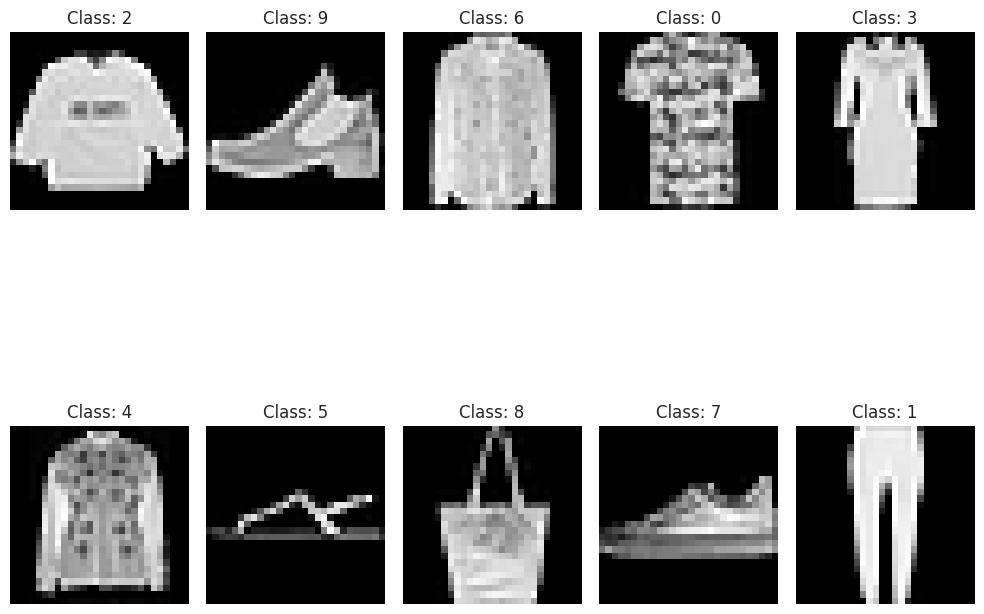

In [ ]:
unique_labels = y_train.unique()
plt.figure(figsize=(10, 10))

for i, label in enumerate(unique_labels):
    index = y_train[y_train == label].index[0]
    image_data = X_train.iloc[index].values.reshape(28, 28)

    plt.subplot(2, 5, i + 1)
    plt.imshow(image_data, cmap='gray')
    plt.title(f"Class: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


scaler_standard = StandardScaler()
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)


scaler_minmax = MinMaxScaler()
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

print("Отнормировано с использованием StandardScaler.")
print("Отнормировано с использованием MinMaxScaler.")

Отнормировано с использованием StandardScaler.
Отнормировано с использованием MinMaxScaler.


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

# Подбор лучших параметров

У KNN есть параметры, которые сильно влияют на работу модели: например, сколько учитывать соседей и как измерять расстояние

GridSearchCV автоматически проверяет все комбинации параметров и выбирает те, которые дают лучшую точность на тренировочных данных с кросс-валидацией


Мы используем CV=5 (5-кратную кросс-валидацию), что позволяет оценить, насколько стабильно модель будет работать на новых данных, а не только на конкретной тренировочной выборке

KNN чувствителен к масштабам признаков, поэтому заранее мы масштабировали данные - без этого одна переменная могла бы перетянуть результат на себя

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Определяем сетку параметров
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'minkowski']
}

knn = KNeighborsClassifier()

# Настраиваем GridSearchCV для KNN, он автоматически перебирает все комбинации параметров из сетки и оценивает их кач-во с помощью кросс-валидации
grid_search_knn = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy')

# Обучение GridSearchCV на тренировочных данных
grid_search_knn.fit(X_train_scaled_standard, y_train)

print("Лучшие параметры для KNN:", grid_search_knn.best_params_)
print("Лучашя cross-validation точность для KNN:", grid_search_knn.best_score_)

Лучшие параметры для KNN: {'metric': 'euclidean', 'n_neighbors': 7}
Лучашя cross-validation точность для KNN: 0.8108854589764419


## Оценка реального качества модели

Данный этап покажет, насколько выбранная модель пригодна для использования



In [ ]:
# Получаем лучшую модель KNN из обученного GridSearchCV
best_knn_model = grid_search_knn.best_estimator_ # объект с оптимальными параметрами, которые мы нашли на предыдущем шаге

# Делаем предсказания на основе масштабированных тестовых данных
y_pred_knn_test = best_knn_model.predict(X_test_scaled_standard)

# Считаем точность на тестовом наборе - сравнение предсказаний модели с настоящими метками и возврат доли правильных ответов
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)

print(f"Точность KNN: {accuracy_knn_test:.4f}")

Точность KNN: 0.8163


**Вывод**:
Мы видим, что модель хорошо работает с оптимальными параметрами на тестовых данных - она предсказывает метку примерно в 82% случаев



Проделаем аналогичную работу для Логистической регрессии.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Определяем сетку параметров
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

logreg = LogisticRegression(max_iter=1000)

# Настраиваем GridSearchCV для Logistic Regression
grid_search_logreg = GridSearchCV(logreg, logreg_param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the scaled training data
grid_search_logreg.fit(X_train_scaled_standard, y_train)

# Обучение GridSearchCV на тренировочных данных
print("Лучшие параметры для Logistic Regression:", grid_search_logreg.best_params_)
print("Лучашя cross-validation точность для Logistic Regression:", grid_search_logreg.best_score_)